<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/FAST%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/cv2/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.11

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class PascalVOCDataset(Dataset):

    def __init__(self, images_dir, annotations_dir,ref_labels, transform=None):
        self.ref_labels=ref_labels #referencia posiciones de cada clase seguira el mismo orden +1
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir

        if(transform is not None):
           self.transform = transform
        else:
          self.transform=transforms.ToTensor()

        # Lista de todas las imágenes y sus anotaciones
        self.image_filenames = [
            f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))
        ]

    def __len__(self):
        """Devuelve el tamaño del dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):

        # Cargar la imagen
        image_filename = self.image_filenames[idx]

        image_path = os.path.join(self.images_dir, image_filename)

        image = Image.open(image_path)

        # Cargar la anotación correspondiente
        annotation_path = os.path.join(
            self.annotations_dir, os.path.splitext(image_filename)[0] + ".xml"
        )

        target = self._parse_annotation(annotation_path)

        rois=self.generate_rois(image)

        image_tensor=transform(image)

        return image_tensor, rois , target['boxes'],target['labels']


    def _parse_annotation(self, annotation_path):

        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            label= (self.ref_labels.index(label))+1
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

            target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.float32),
            }

        return target

    def generate_rois(self,img,max_regiones=2000,fast_mode=False):

      # Crear un objeto de Selective Search
        img_np = np.array(img)
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        image_bgr = cv2.cvtColor(img_np , cv2.COLOR_RGB2BGR)

      # Configurar la imagen para Selective Search
        ss.setBaseImage(image_bgr)


      # Modo rápido o calidad

        if (fast_mode==True):

          ss.switchToSelectiveSearchFast()

        else :
          ss.switchToSelectiveSearchQuality()  # Más preciso pero más lentoiso

      # Ejecutar Selective Search para obtener las regiones propuestas
        rects = ss.process()
        rois = []

        for x, y, w, h in rects:
           rois.append([x, y, x + w, y + h]) #formato xmin,ymin ,xmax,ymax

        num_rois = len(rois)       #nos aseguraremos que la cantiadad de rois generados sea siempre el maximo , sino lo rellenamos con rois de [0,0,0,0]
        if num_rois > max_regiones:
            return torch.tensor(rois[:max_regiones])

        elif num_rois < max_regiones:
            padding = torch.zeros((max_regiones - num_rois, 4), dtype=rois.dtype)
            return torch.cat([rois, padding], dim=0)

        return torch.tensor(rois)




In [34]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/imagenes/69.jpg')
height, width = image.shape[:2]
aspect_ratio = height / width
new_height = int(500 * aspect_ratio)
resized_image = cv2.resize(image, (500, new_height)) #En el paper recomienda que todas las imagenes tengan el mismo ancho para tener mejores regiones propuestas

def generate_rois(img,max_regiones=2000,fast_mode=False):

      # Crear un objeto de Selective Search
        img_np = np.array(img)
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        image_bgr = cv2.cvtColor(img_np , cv2.COLOR_RGB2BGR)

      # Configurar la imagen para Selective Search
        ss.setBaseImage(image_bgr)


      # Modo rápido o calidad

        if (fast_mode==True):

          ss.switchToSelectiveSearchFast()

        else :
          ss.switchToSelectiveSearchQuality()  # Más preciso pero más lentoiso

      # Ejecutar Selective Search para obtener las regiones propuestas
        rects = ss.process()
        rois = []

        for x, y, w, h in rects:
           rois.append([x, y, x + w, y + h]) #formato xmin,ymin ,xmax,ymax

        num_rois = len(rois)       #nos aseguraremos que la cantiadad de rois generados sea siempre el maximo , sino lo rellenamos con rois de [0,0,0,0]
        if num_rois > max_regiones:
            return torch.tensor(rois[:max_regiones])

        elif num_rois < max_regiones:
            padding = torch.zeros((max_regiones - num_rois, 4), dtype=rois.dtype)
            return torch.cat([rois, padding], dim=0)

        return torch.tensor(rois)




In [5]:
#funcion calcular iou para comparar la region propuesta con la real:

def calculateIoU(real_bb, predict_bb):
    xl = max(real_bb[0], predict_bb[0])  # Máximo entre x de cada extremo top_left
    yl = max(real_bb[1], predict_bb[1])  # Máximo entre y de cada extremo top_left
    xr = min(real_bb[2], predict_bb[2])  # Mínimo entre x de cada extremo bottom_right
    yr = min(real_bb[3], predict_bb[3])  # Mínimo entre y de cada extremo bottom_right

    if xl < xr and yl < yr:
        inter_area = (xr - xl) * (yr - yl)
        real_area = (real_bb[2] - real_bb[0]) * (real_bb[3] - real_bb[1])
        pred_area = (predict_bb[2] - predict_bb[0]) * (predict_bb[3] - predict_bb[1])

        iou = inter_area / (real_area + pred_area - inter_area)
        return iou
    else:
        return 0.0




def draw_boxes(img,rects,labels):

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for (x, y, w, h),label in zip(rects,labels):  # Limitar a las primeras 100 regiones para visualizar
        if(label!='fondo'  and label != 0 ):
         cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.putText(image_rgb, str(label), (x, y - int(h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # Mostrar la imagen con Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Ocultar los ejes
    plt.show()


In [6]:
#Selecionar regiones propuestas que iran al  modelo SVM  usando criterio de IoU donde  <0.3 sera considerados como fondo ,0.3< IoU <0.5 sera omitido para evitar ambuiguidad
#Mayores a 0.5> sera clasificado como la clase del bbox que mas se apropixma al IoU.

import random

def select_labels_regiones(regiones, ground_truth_boxes, ground_truth_labels, iou_threshold=0.5, max_fondos_ratio=2):
    labels = []
    regiones_selected = []
    real_bbox_selected = []
    fondos = []  # Para almacenar regiones de fondo temporalmente

    for box, gt_label in zip(ground_truth_boxes, ground_truth_labels):
        for region in regiones:
            iou = calculateIoU(box, region)

            # Seleccionar regiones con IoU suficiente
            if iou >= iou_threshold:
                regiones_selected.append(region)
                real_bbox_selected.append(box)
                labels.append(gt_label)

            # Fondos (opcional: guardar en una lista separada)
            elif 0 < iou < 0.3:
                fondos.append((region, None, 0))  # Guardar como (region, cuadro real, etiqueta)

    # Limitar la cantidad de fondos
    max_fondos = int(len(labels) * max_fondos_ratio)  # Por ejemplo, hasta 2 fondos por cada objeto
    fondos_seleccionados = random.sample(fondos, min(len(fondos), max_fondos))

    # Agregar los fondos seleccionados
    for region, real_box, label in fondos_seleccionados:
        regiones_selected.append(region)
        real_bbox_selected.append(real_box)
        labels.append(label)

    return regiones_selected, real_bbox_selected, labels

#selecionamos el bbox real de cada bbox que se propuesto y contenga un objeto (iou>0.7) y no consideremos el fondo, esto para entrenar el modelo regresor

def select_bbox_regiones(regiones_selected,real_regiones_selected,labels):

    real_bboxs=[]
    regiones=[]
    labels_selected=[]
    for region,real_bbox,label in zip(regiones_selected,real_regiones_selected,labels):

        if label!='fondo' and  label!=0:
            real_bboxs.append(real_bbox)
            regiones.append(region)
            labels_selected.append(label)



    return regiones,real_bboxs,labels_selected





In [75]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion



def calculate_translation(bbox_pred, bbox_real):
    """
    Calcula los deltas para ajustar un bbox predicho a su equivalente real.

    Args:
        bbox_pred: (xmin_pred, ymin_pred, xmax_pred, ymax_pred)
        bbox_real: (xmin_real, ymin_real, xmax_real, ymax_real)

    Returns:
        deltas: (dx, dy, dw, dh) -> Desplazamiento en x, y, ancho y alto.
    """
    # Extracción de coordenadas
    x_center_pred = (bbox_pred[:, 0] + bbox_pred[:, 2]) / 2
    y_center_pred = (bbox_pred[:, 1] + bbox_pred[:, 3]) / 2
    w_pred = bbox_pred[:, 2] - bbox_pred[:, 0]
    h_pred = bbox_pred[:, 3] - bbox_pred[:, 1]

    x_center_real = (bbox_real[:, 0] + bbox_real[:, 2]) / 2
    y_center_real = (bbox_real[:, 1] + bbox_real[:, 3]) / 2
    w_real = bbox_real[:, 2] - bbox_real[:, 0]
    h_real = bbox_real[:, 3] - bbox_real[:, 1]

    # Calcular deltas
    dx = x_center_real - x_center_pred
    dy = y_center_real - y_center_pred
    dw = torch.log(w_real / w_pred)
    dh = torch.log(h_real / h_pred)

    deltas = torch.stack([dx, dy, dw, dh], dim=-1)
    return deltas


import numpy as np

def reverse_translation(bbox_pred, deltas):
    """
    Calcula las coordenadas del bbox real a partir de un bbox predicho y los deltas.

    Args:
        bbox_pred: Tensor de forma (N, 4) con las coordenadas del bbox predicho (xmin_pred, ymin_pred, xmax_pred, ymax_pred).
        deltas: Tensor de forma (N, 4) con los deltas (dx, dy, dw, dh).

    Returns:
        bbox_real: Tensor de forma (N, 4) con las coordenadas del bbox real (xmin_real, ymin_real, xmax_real, ymax_real).
    """
    # Extraer coordenadas y dimensiones del bbox predicho
    x_center_pred = (bbox_pred[:, 0] + bbox_pred[:, 2]) / 2
    y_center_pred = (bbox_pred[:, 1] + bbox_pred[:, 3]) / 2
    w_pred = bbox_pred[:, 2] - bbox_pred[:, 0]
    h_pred = bbox_pred[:, 3] - bbox_pred[:, 1]

    # Extraer deltas
    dx, dy, dw, dh = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    # Calcular dimensiones y centro del bbox real
    x_center_real = x_center_pred + dx
    y_center_real = y_center_pred + dy
    w_real = w_pred * torch.exp(dw)
    h_real = h_pred * torch.exp(dh)

    # Reconstruir las coordenadas (xmin, ymin, xmax, ymax)
    xmin_real = x_center_real - w_real / 2
    ymin_real = y_center_real - h_real / 2
    xmax_real = x_center_real + w_real / 2
    ymax_real = y_center_real + h_real / 2

    # Combinar coordenadas en un tensor
    bbox_real = torch.stack([xmin_real, ymin_real, xmax_real, ymax_real], dim=-1)
    return bbox_real

In [8]:
import torchvision.models as models
from torchvision.ops.roi_pool import RoIPool
import torch.nn as nn
class Fast_RCNN(nn.Module):

 def __init__(self,num_clases):

    super(Fast_RCNN, self).__init__()

    self.backbone = models.vgg16(pretrained=True).to(device) #solo tomamos las capas combolcionales de la red omitinedo el clasificador de la ultima capa
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Exclude final layer que en vgg16 es un avg polling

    # RoI Pooling
    self.roi_pooling = RoIPool((7, 7), spatial_scale=1/16)

    self.flatten = nn.Flatten(start_dim=1)

    # Fully Connected Layers for Classification

    self.fc_cls = nn.Linear(512 * 7 * 7, num_clases)  # 512 es el número de canales de VGG16, 7x7 es el tamaño de RoI Pool

    self.fc_bbox = nn.Linear(512 * 7 * 7, 4)  # Para coordenadas de caja delimitadora (x, y, w, h)

 def forward(self, x,rois):

        # Backbone feature extraction
        x = self.backbone(x)


        x = self.roi_pooling(x,rois)

        # Flatten pooled features
        x = self.flatten(x)

        # Classification
        cls_scores = self.fc_cls(x)

        # Bounding box regression
        bbox_offsets = self.fc_bbox(x)

        return cls_scores, bbox_offsets

In [9]:
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
# Directorios del dataset
images_dir = "/content/imagenes"
annotations_dir = "/content/anotaciones"

# Definir transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte a tensor

])


# Crear el dataset
dataset = PascalVOCDataset(images_dir, annotations_dir,ref_labels=['gato','perro'],transform=transform)

# Particionar dataset en train y test
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # El resto para prueba

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

image, rois , bboxs,labels=train_dataset[0]

print(bboxs.shape)
print(rois.shape)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

first_images, first_rois,first_bboxs,first_labels = next(iter(train_loader))

# Verificar el tamaño de las imágenes
print("Tamaño de las imágenes:", first_images.shape)

# Verificar anotaciones
print("Rois:", first_rois)

torch.Size([1, 4])
torch.Size([2000, 4])
Tamaño de las imágenes: torch.Size([2, 3, 500, 500])
Rois: tensor([[[ 23, 148,  33, 228],
         [  0, 463, 273, 500],
         [144, 128, 208, 163],
         ...,
         [201, 182, 237, 277],
         [150, 316, 178, 392],
         [ 25, 140, 126, 243]],

        [[  0, 440, 104, 496],
         [ 81, 160, 112, 208],
         [ 60,  82,  79, 120],
         ...,
         [132, 190, 345, 452],
         [304, 368, 352, 448],
         [292, 407, 314, 467]]], dtype=torch.int32)


In [15]:
from torchvision.ops import box_iou
import torch

from torchvision.ops import box_iou
import torch
def filter_and_assign_labels(rois, gt_boxes, gt_labels, iou_threshold_pos=0.5, iou_threshold_neg=0.3):
    """
    Filtra ROIs y asigna etiquetas y objetivos de regresión de las cajas.
    - ROIs con IOU >= iou_threshold_pos se consideran positivos.
    - ROIs con IOU < iou_threshold_neg se consideran negativos.
    - ROIs en el rango [iou_threshold_neg, iou_threshold_pos) se descartan.
    """
    batch_size = rois.size(0)
    all_labels = []
    all_bbox_targets = []
    deltas = []
    filtered_rois = []

    for i in range(batch_size):
        # Extraer ROIs, gt_boxes y gt_labels para la imagen actual
        rois_per_image = rois[i]  # [num_rois, 4]
        gt_boxes_per_image = gt_boxes[i]  # [num_gt_boxes, 4]
        gt_labels_per_image = gt_labels[i]  # [num_gt_boxes]

        # Calcular IOU entre ROIs y cajas reales
        ious = box_iou(rois_per_image, gt_boxes_per_image)  # [num_rois, num_gt_boxes]
        max_ious, max_indices = ious.max(dim=1)

        # Inicializar etiquetas como ignoradas (-1)
        labels = torch.full_like(max_ious, -1, dtype=gt_labels_per_image.dtype)

        # ROIs positivos (IOU >= iou_threshold_pos)
        positive_indices = max_ious >= iou_threshold_pos
        labels[positive_indices] = gt_labels_per_image[max_indices[positive_indices]]

        # ROIs negativos (IOU < iou_threshold_neg)
        negative_indices = (0 < max_ious) & (max_ious < iou_threshold_neg)
        labels[negative_indices] = 0  # Fondo

        # Filtrar ROIs (excluyendo los ignorados)
        valid_indices = positive_indices | negative_indices  # >= 0.5 o < 0.3
        filtered_rois_per_image = rois_per_image[valid_indices]

        # Agregar índices de batch
        batch_indices = torch.full(
            (filtered_rois_per_image.size(0), 1), i, dtype=torch.float32, device=rois.device
        )
        filtered_rois_with_batch = torch.cat([batch_indices, filtered_rois_per_image], dim=1)  # [num_valid_rois, 5]

        # Objetivos de regresión de cajas
        bbox_targets = torch.zeros_like(rois_per_image, dtype=gt_boxes_per_image.dtype)
        bbox_targets[positive_indices] = gt_boxes_per_image[max_indices[positive_indices]]

        # Calcula los deltas
        deltas_batch = torch.zeros_like(bbox_targets)
        deltas_batch[positive_indices] = calculate_translation(bbox_targets[positive_indices], gt_boxes_per_image[max_indices[positive_indices]])

        # Guardar resultados solo si hay elementos
        if filtered_rois_with_batch.size(0) > 0:
            filtered_rois.append(filtered_rois_with_batch)
            all_labels.append(labels[valid_indices])
            all_bbox_targets.append(bbox_targets[valid_indices])
            deltas.append(deltas_batch[valid_indices])

    # Combinar resultados de todos los lotes solo si hay elementos
    if filtered_rois:
        filtered_rois = torch.cat(filtered_rois, dim=0)  # [K, 5]
        all_labels = torch.cat(all_labels, dim=0).long()
        all_bbox_targets = torch.cat(all_bbox_targets, dim=0).float()
        deltas = torch.cat(deltas, dim=0).float()
    else:
        filtered_rois = torch.empty((0, 5))
        all_labels = torch.empty(0, dtype=torch.long)
        all_bbox_targets = torch.empty(0, dtype=torch.float32)
        deltas = torch.empty(0, dtype=torch.float32)

    return filtered_rois, all_labels, all_bbox_targets, deltas


In [11]:
import torch

def prepare_rois(rois):
    """
    Convierte ROIs de [batch_size, num_rois, 4] a [K, 5].
    Añade un índice de lote como la primera columna.

    Args:
        rois (torch.Tensor): Tensor de ROIs con forma [batch_size, num_rois, 4].

    Returns:
        torch.Tensor: Tensor de ROIs con forma [K, 5].
    """
    batch_size, num_rois, _ = rois.shape

    # Crear una columna con los índices de lote
    batch_indices = torch.arange(batch_size, device=rois.device).unsqueeze(1).repeat(1, num_rois)
    batch_indices = batch_indices.flatten()  # Forma [K]

    # Aplanar las ROIs
    rois_flattened = rois.view(-1, 4)  # Forma [K, 4]

    # Concatenar los índices de lote con las ROIs
    rois_prepared = torch.cat([batch_indices.unsqueeze(1), rois_flattened], dim=1)  # Forma [K, 5]

    return rois_prepared

In [16]:
#ENTRENANDO MODELO:

import torch.optim as optim

# Función de pérdida
criterion_cls = nn.CrossEntropyLoss() # YA APLICA SOFTAMAX A LAS SALIDAS
criterion_bbox = nn.SmoothL1Loss() #Para regresion

model=Fast_RCNN(num_clases=3) #fondo ,gato , perro 3 clases
model=model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epocas=10

for epoch in range(num_epocas):
    model.train()
    running_loss = 0.0

    for images, rois, gt_boxes, gt_labels in train_loader:

        images = images.to(device)
        rois = rois.to(device)
        gt_boxes = gt_boxes.to(device)
        gt_labels = gt_labels.to(device)

        optimizer.zero_grad()

        # Asignar etiquetas y objetivos a los ROIs
        filtered_rois,labels, bbox_targets,deltas = filter_and_assign_labels(rois, gt_boxes, gt_labels)

        #rois_prepared = prepare_rois(filtered_rois)
        #rois_prepared = rois_prepared.to(dtype=torch.float)
        # Forward pass
        class_logits, bbox_deltas = model(images, filtered_rois)


        loss_cls = criterion_cls(class_logits, labels)
        loss_bbox = criterion_bbox(bbox_deltas, deltas)
        loss = loss_cls + (0.8*loss_bbox)

          # Retropropagación y optimización
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epocas}], Loss: {running_loss / len(train_loader)}")



Epoch [1/10], Loss: 1.0746648822511946
Epoch [2/10], Loss: 1.064934377159391
Epoch [3/10], Loss: 1.0586379425866264
Epoch [4/10], Loss: 1.0557355433702469
Epoch [5/10], Loss: 1.05148150239672
Epoch [6/10], Loss: 1.0460029137986047
Epoch [7/10], Loss: 1.043376088142395
Epoch [8/10], Loss: 1.0390796107905251
Epoch [9/10], Loss: 1.0338125633341926
Epoch [10/10], Loss: 1.0314663435731615


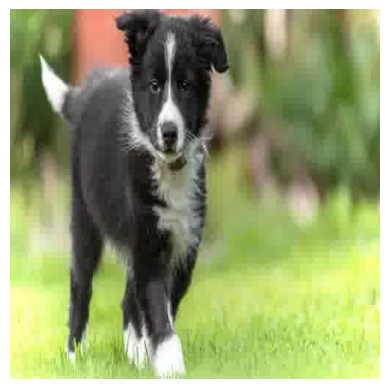

In [182]:


image = cv2.imread("/content/imagenes/63.jpg")

resized_image = cv2.resize(image, (500, 500)) #En el paper recomienda que todas las imagenes tengan el mismo ancho para tener mejores regiones propuestas

rois=generate_rois(resized_image,max_regiones=2000,fast_mode=False)

batch_indices = torch.zeros((rois.size(0), 1), dtype=torch.float32)

# Concatenar el índice del lote al inicio de cada ROI
rois_with_index = torch.cat((batch_indices, rois), dim=1).to(device)



# SVM modelo

transform = transforms.Compose([
    transforms.ToTensor()  # Convierte a tensor

])

imagen_tensor=transform(resized_image).to(device)

class_logits, bbox_deltas = model(imagen_tensor.unsqueeze(0),rois_with_index)

probs = F.softmax(class_logits, dim=1)

pred_bbox_reales=reverse_translation(rois.to(device), bbox_deltas).to(device)

pred_bbox_reales=pred_bbox_reales.to(device)

import torch.nn.functional as F

image_with_bbox=resized_image.copy()

for prob, pred_bbox_real,roi in zip(probs,pred_bbox_reales,rois):

    max_probs, max_indices = torch.max(prob, dim=0)

    if(max_probs>0.8 and max_indices>0 ):
      print(max_indices)
      xmin, ymin, xmax, ymax = map(int, pred_bbox_real)  # Convertir las coordenadas a enteros

      color = (0, 255, 0)  # Color del rectángulo (verde en formato BGR)
      thickness = 2        # Espesor de la línea del rectángulo
      font = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 0.6  # Tamaño del texto
      font_thickness = 2
      text_color = (0, 255, 0)  # Color del texto (blanco)
      bg_color = (0, 255, 0)

      image_with_bbox = cv2.rectangle(image_with_bbox, (xmin, ymin), (xmax, ymax), color, thickness)
      cv2.putText(image_with_bbox, str(max_indices.cpu().numpy()), (xmin, ymin - 5), font, font_scale, text_color, font_thickness)

# Convertir de BGR a RGB para usar con matplotlib
image_with_bbox_rgb = cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con matplotlib
plt.imshow(image_with_bbox_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()






